### 1.

Implement a Metropolis-within-Gibbs algorithm to sample from the posterior of a "location-scale-t-norm-halfnorm-discrete-uniform" specification.

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
n = 100; true_mu = 0; true_sigma = 1; true_nu = 15
x = stats.t(df=true_nu, loc=true_mu, scale=true_sigma^2).rvs(size=n)
C, G = 2, 10000  # Chains, Gibbs samples
mu, sigma, nu = np.zeros([C, G]), np.zeros([C, G]), np.zeros([C, G])
mu[:, 0], sigma[:, 0], nu[:, 0] = 0.1, 1.1, 15.1

# Set Priors
mu_prior = stats.norm(loc=0.5, scale=1/np.sqrt(1.5))
sigma_prior = stats.halfnorm(scale=5)
nu_frames = np.arange(1, 101); nu_pmf = np.full_like(nu_frames, 1/100, dtype=float)
nu_prior = stats.rv_discrete(name='nu_prior', values=(nu_frames, nu_pmf))

# Full conditional calculators
mu_post = lambda mu_: np.prod(stats.t(true_nu, loc=mu_, scale=true_sigma).pdf(x)) * mu_prior.pdf(mu_)
sigma_post = lambda sigma_: np.prod(stats.t(true_nu, loc=true_mu, scale=sigma_).pdf(x)) * sigma_prior.pdf(sigma_)
nu_post = lambda nu_: np.prod(stats.t(nu_, loc=true_mu, scale=true_sigma).pdf(x)) * nu_prior.pmf(nu_)

In [ ]:
for c in range(C):
    for g in range(1, G):
        mu_prop = mu_prior; mu_tilde = mu_prop.rvs()
        mh_mu = (np.log(mu_post(mu_tilde)) + np.log(mu_prop.pdf(mu[c, g-1]))) - (np.log(mu_post(mu[c, g-1])) + np.log(mu_prop.pdf(mu[c, g-1])))
        mu[c, g] = mu_tilde if np.log(stats.uniform.rvs()) < min(0, mh_mu) else mu[c, g-1]

        sigma_prop = sigma_prior; sigma_tilde = sigma_prop.rvs()
        mh_sigma = (np.log(sigma_post(sigma_tilde)) + np.log(sigma_prop.pdf(sigma[c, g-1]))) - (np.log(sigma_post(sigma[c, g-1])) + np.log(sigma_prop.pdf(sigma[c, g-1])))
        sigma[c, g] = sigma_tilde if np.log(stats.uniform.rvs()) < min(0, mh_sigma) else sigma[c, g-1]

        nu_prop = nu_prior; nu_tilde = nu_prop.rvs()
        mh_nu = (np.log(nu_post(nu_tilde)) + np.log(nu_prop.pmf(nu[c, g-1]))) - (np.log(nu_post(nu[c, g-1])) + np.log(nu_prop.pmf(nu[c, g-1])))
        nu[c, g] = nu_tilde if np.log(stats.uniform.rvs()) < min(0, mh_nu) else nu[c, g-1]

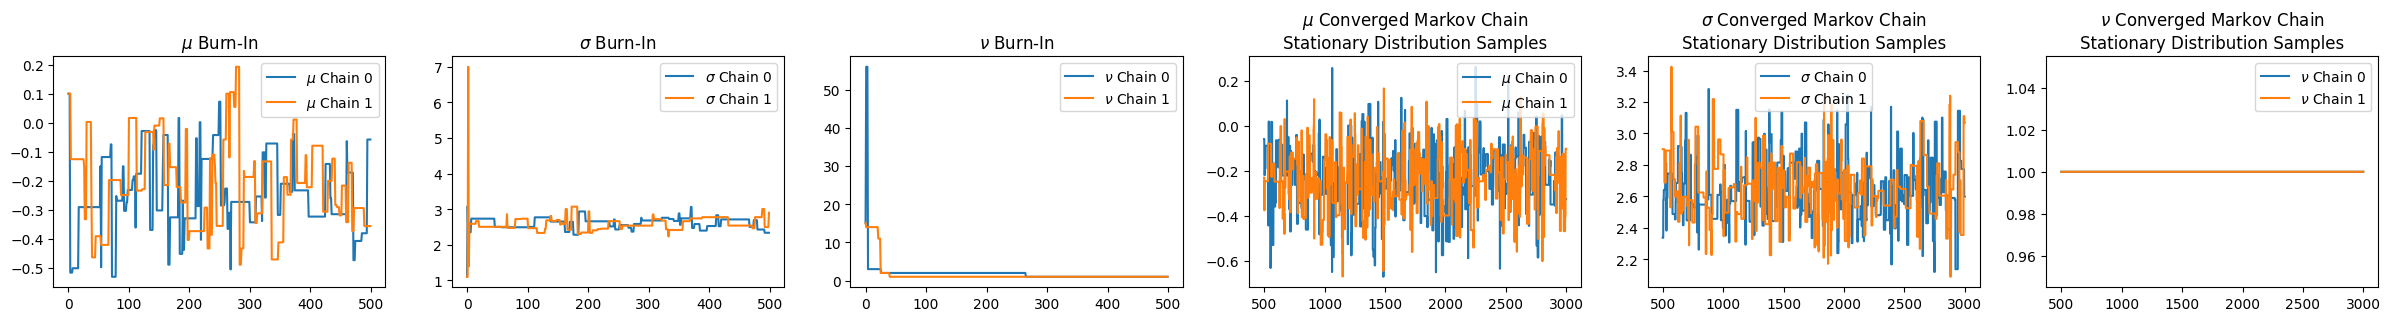

In [ ]:
fig,ax = plt.subplots(1, 6, figsize=(30,3));
ax[0].set_title("$\\mu$ Burn-In");
ax[1].set_title("$\\sigma$ Burn-In");
ax[2].set_title("$\\nu$ Burn-In");
ax[3].set_title("$\\mu$ Converged Markov Chain\nStationary Distribution Samples");
ax[4].set_title("$\\sigma$ Converged Markov Chain\nStationary Distribution Samples");
ax[5].set_title("$\\nu$ Converged Markov Chain\nStationary Distribution Samples");
burn = 500
demo = 3000
for c in range(C):
    ax[0].plot(mu[c,:burn], label="$\\mu$ Chain "+str(c))
    ax[1].plot(sigma[c,:burn], label="$\\sigma$ Chain "+str(c))
    ax[2].plot(nu[c,:burn], label="$\\nu$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), mu[c,burn:demo], label="$\\mu$ Chain "+str(c))
    ax[4].plot(np.arange(burn, demo, dtype=int), sigma[c,burn:demo], label="$\\sigma$ Chain "+str(c))
    ax[5].plot(np.arange(burn, demo, dtype=int), nu[c,burn:demo], label="$\\nu$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); ax[4].legend(); ax[5].legend();

### Q2.

Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.

In [ ]:
import pymc as pm
import arviz as az

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

Output()

Output()

Output()

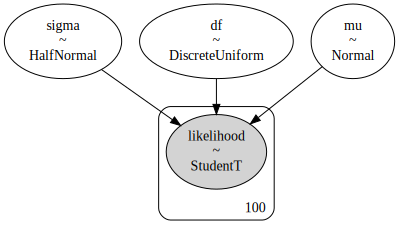

In [ ]:
with pm.Model() as BIGModel:
    mu = pm.Normal('mu', mu=0.5, tau=1.5)
    sigma = pm.HalfNormal("sigma", sigma=5)
    nu = pm.DiscreteUniform("df", lower=1, upper=100)
    likelihood = pm.StudentT("likelihood", nu=nu, mu=mu, sigma=sigma, observed=x)

    sample_sizes = [100, 500, 1000, 2000, 5000, 10000]
    idata_ = []
    for size in sample_sizes:
        idata_.append(pm.sample(draws=size, chains=4, tune=1000))

pm.model_to_graphviz(BIGModel)

           mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
df     64.97750  25.14982  22.00000  100.00000    3.29477  2.95753   67.32026   
mu     -0.16328   0.26930  -0.68496    0.29818    0.01242  0.01095  468.51071   
sigma   2.75136   0.20512   2.37833    3.14577    0.01153  0.00817  319.21732   

        ess_tail    r_hat  
df      76.13618  1.07052  
mu     313.34866  1.00886  
sigma  318.92470  1.00551  
           mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
df     56.73850  25.46716  17.00000  100.00000    1.19155  0.88323   
mu     -0.16267   0.26059  -0.63945    0.30873    0.00556  0.00522   
sigma   2.72621   0.19701   2.33922    3.07642    0.00479  0.00339   

         ess_bulk    ess_tail    r_hat  
df      439.94379   435.41420  1.00923  
mu     2215.13049  1475.60327  1.00121  
sigma  1686.24033  1350.87370  1.00364  
           mean        sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
df     54.49525  26.18367  12.00000  

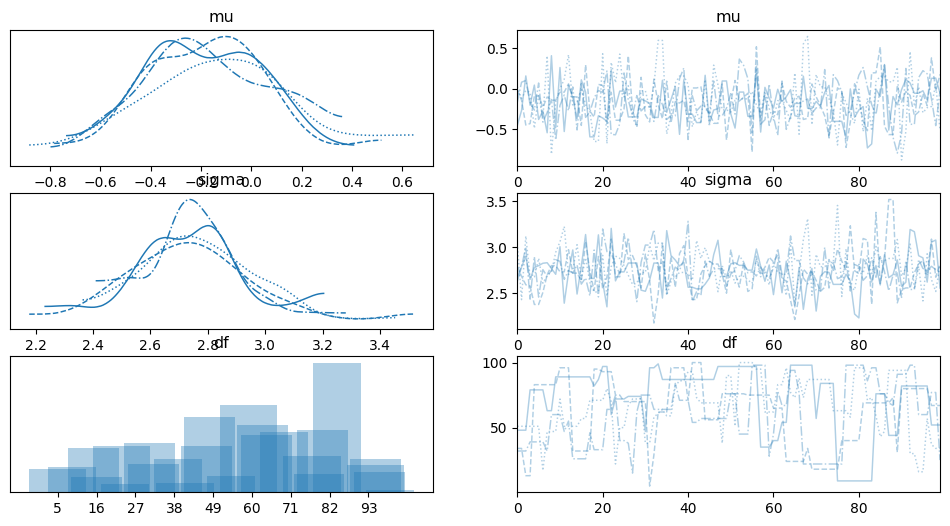

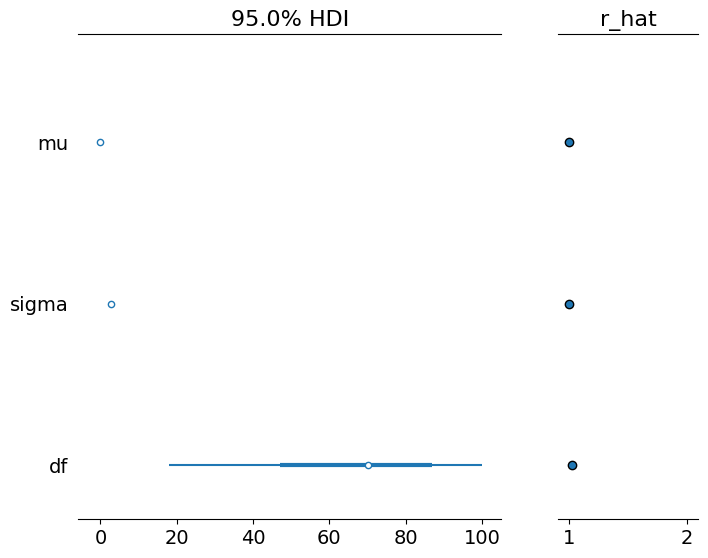

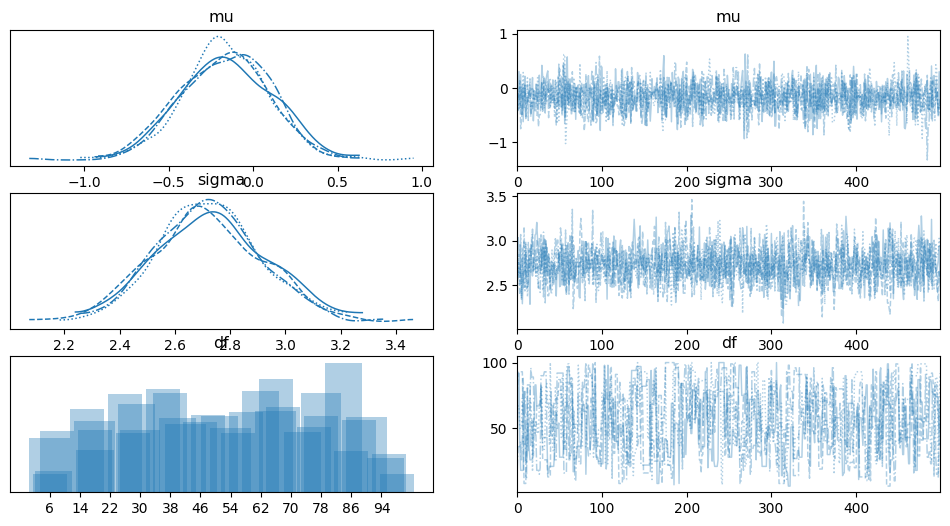

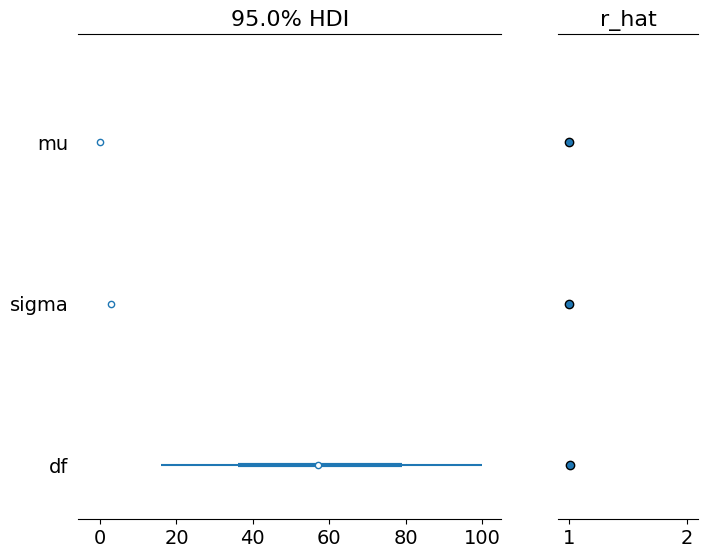

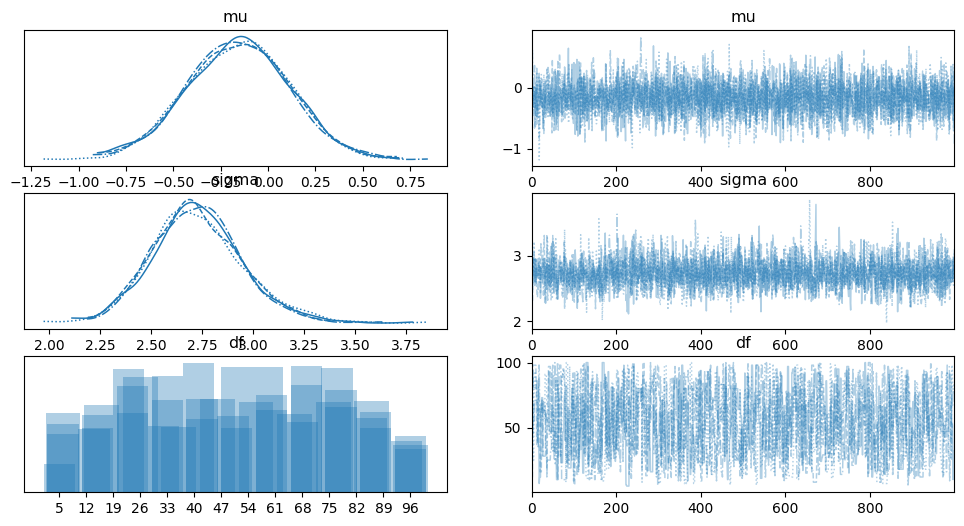

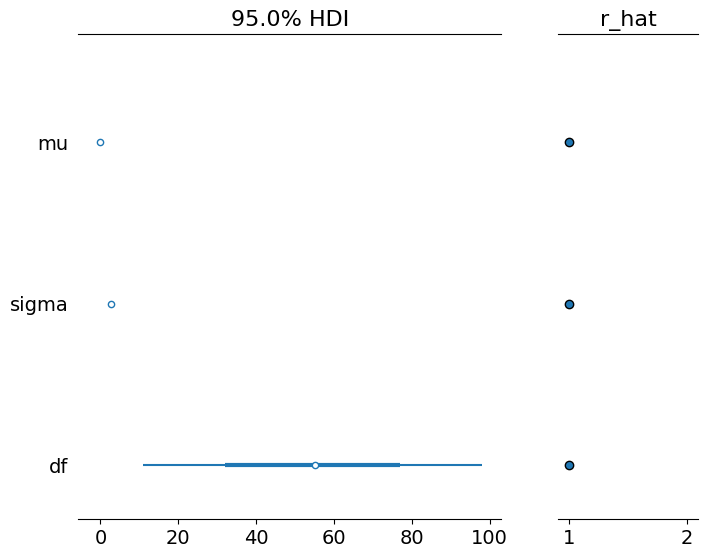

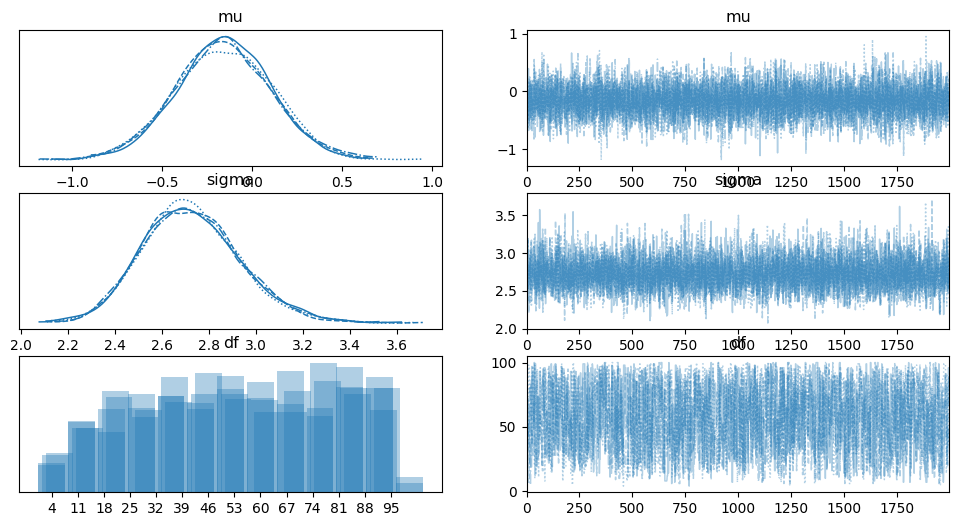

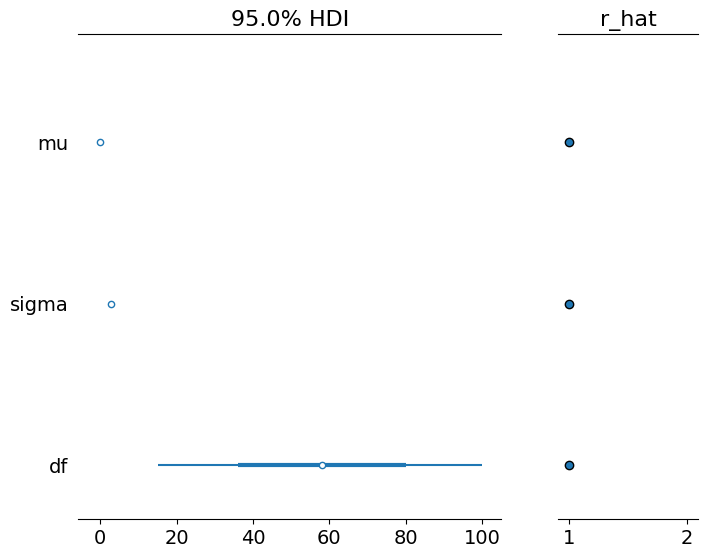

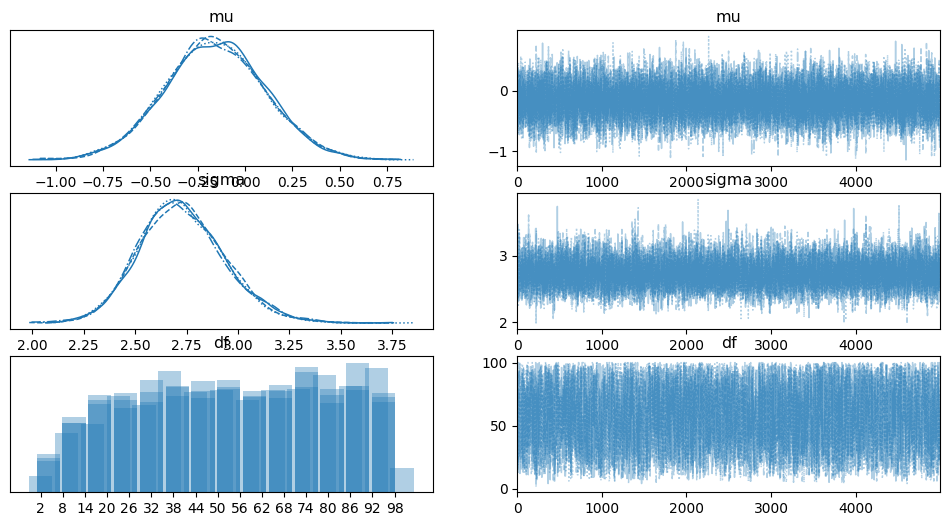

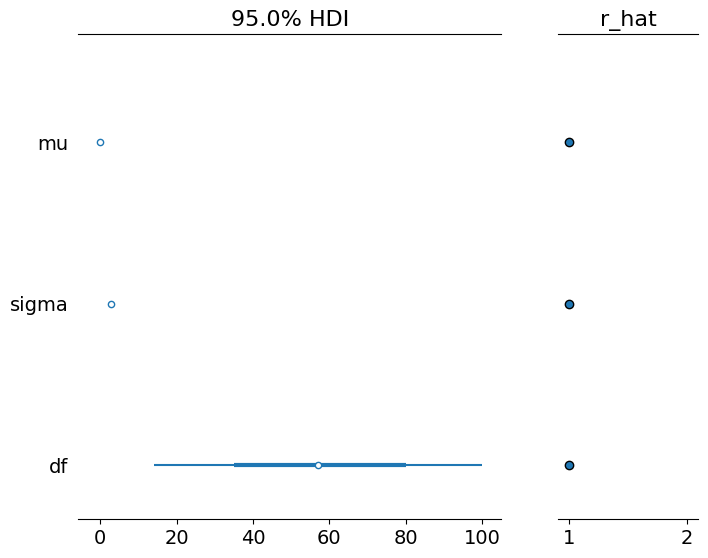

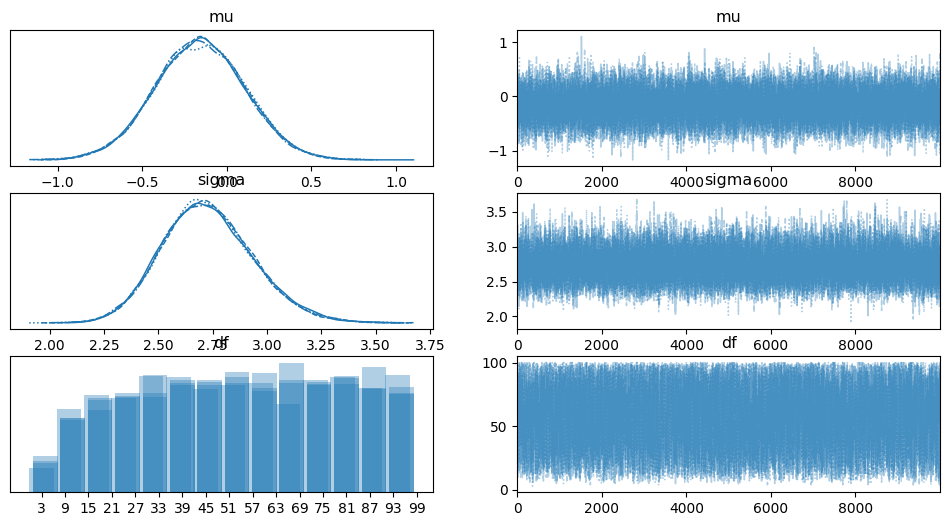

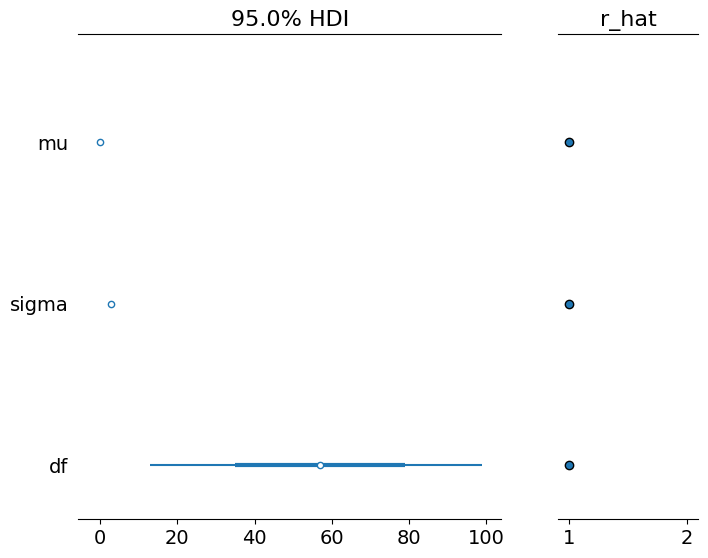

In [61]:
for i in range(len(idata_)):
    az.plot_trace(idata_[i], var_names=["mu", "sigma", "df"])
    az.plot_forest(idata_[i], var_names=["mu", "sigma", "df"], combined=True, hdi_prob=0.95, r_hat=True)

for i in range(len(idata_)):
    print(az.summary(idata_[i], round_to=5))

### Q3.

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

\begin{align*}
  \int p(y_i|\tau_i) p(\tau_i)  d\tau_i &= \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \cdot \frac{\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left( \frac{\nu}{2} \right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i\\
  &= \left( \dfrac{\frac{v}{2}^{\frac{v}{2}}}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2})}\right) \int{\tau_i^{\frac{v+1}{2}-1}e^{-\frac{(y_i^2 + v)}{2}}}d\tau_i\\
  &= \left( \dfrac{\frac{v}{2}^{\frac{v}{2}}\cdot \Gamma(\frac{v+1}{2})}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2}) \cdot \left(\frac{y_i^2 + v}{2} \right)^{\frac{v+1}{2}}} \right) \int{\dfrac{\left(\frac{y_i^2 + v}{2} \right)^{\frac{v+1}{2}}}{\Gamma(\frac{v+1}{2})}} \tau_i^{\frac{v+1}{2}-1}e^{-\frac{(y_i^2 - v)}{2}} d\tau_i\\
  &= \dfrac{\frac{v}{2}^{\frac{v}{2}}\cdot \Gamma(\frac{v+1}{2})}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2}) \cdot \left(\frac{y_i^2 + v}{2}\right)^{\frac{v+1}{2}}}\\
  &= \dfrac{\frac{v}{2}^{\frac{v}{2}}\cdot \Gamma(\frac{v+1}{2})}{\sqrt{2\pi} \cdot \Gamma(\frac{v}{2})} \left( 1 + \frac{y_i^2}{v}\right)^{-\frac{(v+1)}{2}} \left(\frac{v}{2}\right)^{-\frac{(v+1)}{2}}\\
  &= \dfrac{\Gamma(\frac{v+1}{2})}{\sqrt{\pi v} \cdot \Gamma(\frac{v}{2})} \left(1 + \frac{y_i^2}{v}\right)^{-\frac{(v+1)}{2}}
\end{align*}

Here, we can see that after integrating out the uncertainty in $\tau_i$, it follows a Student's t-distribution with $\nu$ as its df. This is analogous to the posterior predictive distribution as we integrated out the uncertainty concerning our beliefs about the parameter value like a posterior predictive distribution, but instead we integrated our prior beliefs rather than our updated beliefs.